In [70]:
import os
import cv2 #open cv
import numpy as np
import matplotlib.pyplot as plt


## Load data

In [71]:
def load_dataset(dataset_path):
    data = []
    labels = []
    label_id = 0
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)

        if os.path.isdir(folder_path):
            for img_path in os.listdir(folder_path):
                # test if img_path is a valid file
                if not (img_path.endswith(".jpeg") or img_path.endswith(".jpg")) :
                    print("Skipping file: ", img_path)
                    continue
                img = cv2.imread(os.path.join(folder_path, img_path), cv2.IMREAD_GRAYSCALE)
                #print(img, os.path.join(folder_path, img_path))
                if img is None:
                    print("Error: Could not read the image")
                else:
                    img_resized = cv2.resize(img, (32, 32))
                    img_flattened = img_resized.flatten()
                    
                    data.append(img_flattened)
                    labels.append(label_id)
            label_id =1

    return np.array(data), np.array(labels)

dataset_test_path = "../data/chest_Xray/test"
dataset_train_path = "../data/chest_Xray/train"
dataset_train_aug_path = "../data/chest_Xray/train_augmented"


In [72]:
# load data
# pas besoin du train test split puisque les donées sont déjà filter dans les sous dossiers
X_train, y_train = load_dataset(dataset_train_path)
X_train_aug, y_train_aug = load_dataset(dataset_train_aug_path)
# X_train = np.concatenate((X_train, X_train_aug))
# y_train = np.concatenate((y_train, y_train_aug))
X_test, y_test = load_dataset(dataset_test_path)


Skipping file:  .DS_Store
Skipping file:  .DS_Store


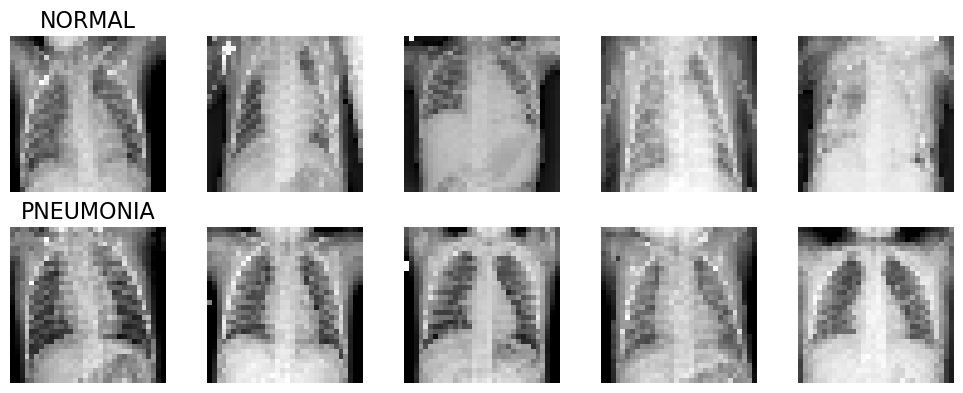

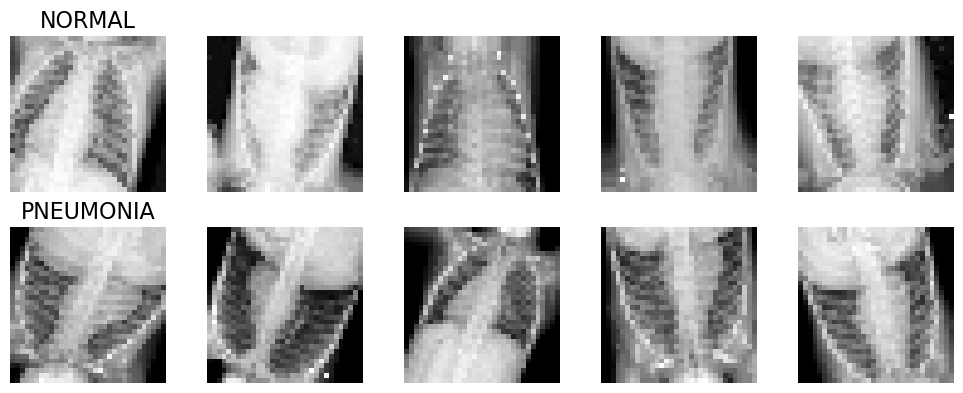

In [73]:
def visualize_data(data, labels, label_names, num_images_per_class=10):
    num_classes = len(set(labels))
    fig, axes = plt.subplots(num_classes, num_images_per_class, figsize=(num_images_per_class * 2, num_classes * 2))
    
    for label_id in range(num_classes):
        label_indices = np.where(labels == label_id)[0]
        sample_indices = np.random.choice(label_indices, size=num_images_per_class, replace=False)

        for i, img_index in enumerate(sample_indices):
            img = data[img_index].reshape(32, 32)
            axes[label_id, i].imshow(img, cmap='gray')
            axes[label_id, i].axis('off')

            if i == 0:
                axes[label_id, i].set_title(label_names[label_id], fontsize=16)

    plt.tight_layout()
    plt.show()

label_names = ["NORMAL", "PNEUMONIA"]
visualize_data(X_train, y_train, label_names, num_images_per_class=5)
visualize_data(X_train_aug, y_train_aug, label_names, num_images_per_class=5)

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Linear SVC
Sépare les données en 2 classes ou plus, maximise la marge entre les classes. Plus la marge est important plus le modèle est précis


In [75]:

def createLinearSVC(max_iter,X,y):
    svc = LinearSVC(random_state=0, max_iter=max_iter)
    svc.fit(X, y)
    return svc



In [76]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score,roc_curve,auc
import matplotlib.pyplot as plt
import seaborn as sns




def qualityModelPrediction(model,X,y):

    y_pred = cross_val_predict(model, X, y, cv=5)

    # Utiliser la fonction cross_val_score pour évaluer la qualité des prédictions
    accuracy_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    precision_scores = cross_val_score(model, X, y, cv=5, scoring='precision')
    recall_scores = cross_val_score(model, X, y, cv=5, scoring='recall')
    f1_scores = cross_val_score(model, X, y, cv=5, scoring='f1')

    print("*********************")
    print("   Qualité de la prédiction   ")
    print("*********************")

    # Afficher les scores de validation croisée
    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
    print("Precision: %0.2f (+/- %0.2f)" % (precision_scores.mean(), precision_scores.std() * 2))
    print("Recall: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() * 2))
    print("F1-score: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))

    # Afficher la matrice de confusion
    conf_mat = confusion_matrix(y, y_pred)
    print(conf_mat)

    # Afficher le rapport de classification
    class_rep = classification_report(y, y_pred)
    print(class_rep)


def showConfusionMatrixHeatMap(cm):
    # Confusion Matrix Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix Heatmap")
    plt.show()

def showRocCurveAuc(y_test, y_pred):

    # ROC Curve and AUC (for binary classification)
    if len(label_names) == 2:
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')

def evaluateModel(model, X_test, y_test):

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Compute evaluation metrics on the test data
    accuracy_scores = accuracy_score(y_test, y_pred)
    precision_scores = precision_score(y_test, y_pred, average='weighted')
    recall_scores = recall_score(y_test, y_pred, average='weighted')
    f1_scores = f1_score(y_test, y_pred, average='weighted')
    
    print("*********************")
    print("   Evaluation du modèle   ")
    print("*********************")

    # Print evaluation metrics
    print("Accuracy on test data: %0.2f" % accuracy_scores)
    print("Precision on test data: %0.2f" % precision_scores)
    print("Recall on test data: %0.2f" % recall_scores)
    print("F1-score on test data: %0.2f" % f1_scores)

    # Compute and display the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    print("Confusion matrix on test data:")
    print(conf_mat)

    # Display the classification report
    class_rep = classification_report(y_test, y_pred)
    print("Classification report on test data:")
    print(class_rep)

    # Display the confusion matrix heatmap
    showConfusionMatrixHeatMap(conf_mat)
    # Display the ROC curve and AUC
    showRocCurveAuc(y_test, y_pred)

/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/judevl/m

*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.94 (+/- 0.01)
Precision: 0.87 (+/- 0.03)
Recall: 0.90 (+/- 0.03)
F1-score: 0.88 (+/- 0.03)
[[3694  181]
 [ 137 1204]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3875
           1       0.87      0.90      0.88      1341

    accuracy                           0.94      5216
   macro avg       0.92      0.93      0.92      5216
weighted avg       0.94      0.94      0.94      5216

*********************
   Evaluation du modèle   
*********************
Accuracy on test data: 0.76
Precision on test data: 0.81
Recall on test data: 0.76
F1-score on test data: 0.73
Confusion matrix on test data:
[[392   6]
 [148  94]]
Classification report on test data:
              precision    recall  f1-score   support

           0       0.73      0.98      0.84       398
           1       0.94      0.39      0.55       242

    accuracy                    

/Users/judevl/miniconda3/envs/venv-mac/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


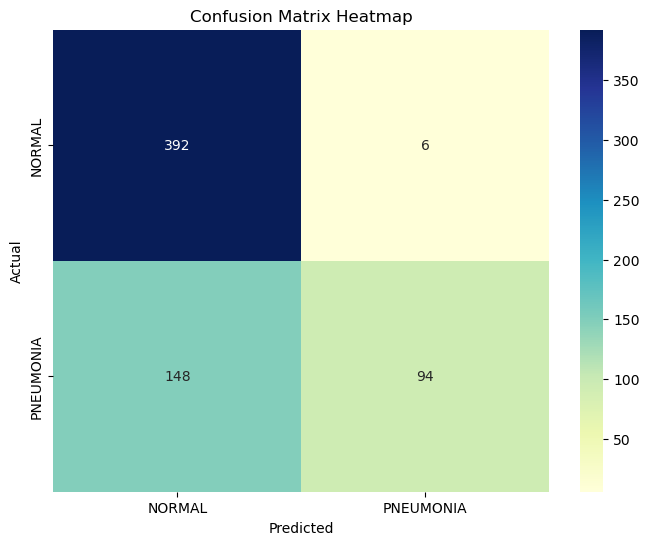

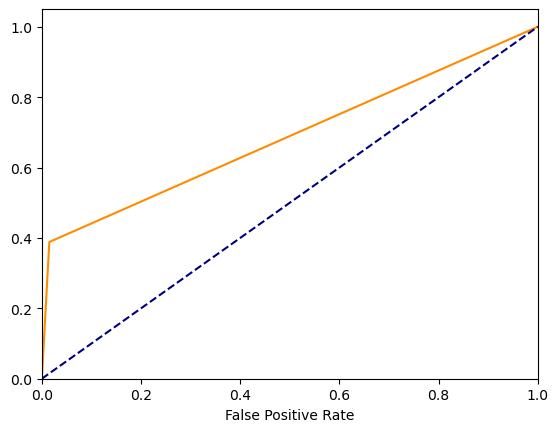

In [77]:


svc = createLinearSVC(max_iter=200,X=X_train,y=y_train)

qualityModelPrediction(model=svc,X=X_train,y=y_train)
evaluateModel(model=svc,X_test=X_test,y_test=y_test)


## Save Model
## Load Model


In [78]:
import pickle
import os



def saveModel(model,model_name,augmented_data=False):
   
    # obtenir le répertoire de travail actuel
    cwd = os.getcwd()

    if augmented_data == True:
        data_path = "augmented"
    else:
        data_path = "original"

    # construire le chemin relatif pour le dossier de stockage des modèles
    model_folder_path = os.path.join(cwd, "sk_models")

    # créer le dossier si nécessaire
    if not os.path.exists(model_folder_path):
        os.mkdir(model_folder_path)

    model_folder_path = os.path.join(model_folder_path, data_path)

    # créer le dossier si nécessaire
    if not os.path.exists(model_folder_path):
        os.mkdir(model_folder_path)

    # construire le chemin complet pour le modèle
    model_path = os.path.join(model_folder_path, model_name + ".pkl")

    # enregistrer le modèle
    with open(model_path, 'wb') as file:
        pickle.dump(model, file)

def loadModel(model_name,augmented_data=False):
     # obtenir le répertoire de travail actuel
    cwd = os.getcwd()

    if augmented_data == True:
        data_path = "augmented"
    else:
        data_path = "original"

    # construire le chemin relatif pour le dossier de stockage des modèles
    model_folder_path = os.path.join(cwd, "sk_models")

    model_folder_path = os.path.join(model_folder_path, data_path)

    # construire le chemin complet pour le modèle
    model_path = os.path.join(model_folder_path, model_name + ".pkl")

    # lire le modèle
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    return model

In [79]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=20, weights="uniform")
neigh.fit(X_train, y_train)
saveModel(neigh,"kneighbors")
neighLoadModel=loadModel("kneighbors")
qualityModelPrediction(model=neighLoadModel,X=X_train,y=y_train)

*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.92 (+/- 0.01)
Precision: 0.97 (+/- 0.04)
Recall: 0.71 (+/- 0.05)
F1-score: 0.82 (+/- 0.03)
[[3840   35]
 [ 385  956]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3875
           1       0.96      0.71      0.82      1341

    accuracy                           0.92      5216
   macro avg       0.94      0.85      0.88      5216
weighted avg       0.92      0.92      0.92      5216



#### SVC model

In [80]:
from sklearn.svm import SVC

svc = SVC(kernel="linear", C=1, random_state=0)
svc.fit(X_train, y_train)
qualityModelPrediction(model=svc,X=X_train,y=y_train)


*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.95 (+/- 0.01)
Precision: 0.90 (+/- 0.03)
Recall: 0.90 (+/- 0.03)
F1-score: 0.90 (+/- 0.01)
[[3738  137]
 [ 137 1204]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      3875
           1       0.90      0.90      0.90      1341

    accuracy                           0.95      5216
   macro avg       0.93      0.93      0.93      5216
weighted avg       0.95      0.95      0.95      5216



#### XGB model

In [81]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier(random_state=0, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)
qualityModelPrediction(model=xgb_classifier,X=X_train,y=y_train)


*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.96 (+/- 0.01)
Precision: 0.95 (+/- 0.01)
Recall: 0.90 (+/- 0.03)
F1-score: 0.92 (+/- 0.02)
[[3816   59]
 [ 137 1204]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3875
           1       0.95      0.90      0.92      1341

    accuracy                           0.96      5216
   macro avg       0.96      0.94      0.95      5216
weighted avg       0.96      0.96      0.96      5216



In [82]:
from sklearn.tree import DecisionTreeClassifier 

decision_tree_classifier = DecisionTreeClassifier(random_state=0)
decision_tree_classifier.fit(X_train, y_train)
qualityModelPrediction(model=decision_tree_classifier,X=X_train,y=y_train)

*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.88 (+/- 0.02)
Precision: 0.77 (+/- 0.06)
Recall: 0.75 (+/- 0.02)
F1-score: 0.76 (+/- 0.02)
[[3578  297]
 [ 337 1004]]
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      3875
           1       0.77      0.75      0.76      1341

    accuracy                           0.88      5216
   macro avg       0.84      0.84      0.84      5216
weighted avg       0.88      0.88      0.88      5216



In [83]:
from sklearn.ensemble import RandomForestClassifier 


random_forest_classifier = RandomForestClassifier(n_estimators=10, max_depth=None,
    min_samples_split=2, random_state=0)
random_forest_classifier.fit(X_train, y_train)
qualityModelPrediction(model=random_forest_classifier,X=X_train,y=y_train)

*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.93 (+/- 0.02)
Precision: 0.92 (+/- 0.06)
Recall: 0.79 (+/- 0.05)
F1-score: 0.85 (+/- 0.04)
[[3788   87]
 [ 285 1056]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3875
           1       0.92      0.79      0.85      1341

    accuracy                           0.93      5216
   macro avg       0.93      0.88      0.90      5216
weighted avg       0.93      0.93      0.93      5216



In [84]:
from sklearn.ensemble import ExtraTreesClassifier 


extra_tree_classifier = ExtraTreesClassifier(n_estimators=100, max_depth=None,
    min_samples_split=2, random_state=0)
extra_tree_classifier.fit(X_train, y_train)
qualityModelPrediction(model=extra_tree_classifier,X=X_train,y=y_train)

*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.95 (+/- 0.02)
Precision: 0.95 (+/- 0.04)
Recall: 0.84 (+/- 0.06)
F1-score: 0.89 (+/- 0.04)
[[3812   63]
 [ 217 1124]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      3875
           1       0.95      0.84      0.89      1341

    accuracy                           0.95      5216
   macro avg       0.95      0.91      0.93      5216
weighted avg       0.95      0.95      0.95      5216



In [85]:
from sklearn.ensemble import AdaBoostClassifier 


ada_boost_classifier = AdaBoostClassifier(n_estimators=100)
ada_boost_classifier.fit(X_train, y_train)
qualityModelPrediction(model=ada_boost_classifier,X=X_train,y=y_train)

*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.95 (+/- 0.01)
Precision: 0.92 (+/- 0.03)
Recall: 0.89 (+/- 0.05)
F1-score: 0.90 (+/- 0.02)
[[3764  111]
 [ 150 1191]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      3875
           1       0.91      0.89      0.90      1341

    accuracy                           0.95      5216
   macro avg       0.94      0.93      0.93      5216
weighted avg       0.95      0.95      0.95      5216



In [86]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)
gradient_boosting_classifier.fit(X_train, y_train)
qualityModelPrediction(model=gradient_boosting_classifier,X=X_train,y=y_train)

*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.93 (+/- 0.01)
Precision: 0.89 (+/- 0.02)
Recall: 0.85 (+/- 0.04)
F1-score: 0.87 (+/- 0.03)
[[3737  138]
 [ 204 1137]]
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      3875
           1       0.89      0.85      0.87      1341

    accuracy                           0.93      5216
   macro avg       0.92      0.91      0.91      5216
weighted avg       0.93      0.93      0.93      5216



In [87]:
from sklearn.ensemble import HistGradientBoostingClassifier

hist_gradient_boosting_classifier = HistGradientBoostingClassifier(max_iter=100)
hist_gradient_boosting_classifier.fit(X_train, y_train)
qualityModelPrediction(model=hist_gradient_boosting_classifier,X=X_train,y=y_train)

*********************
   Qualité de la prédiction   
*********************
Accuracy: 0.96 (+/- 0.01)
Precision: 0.95 (+/- 0.02)
Recall: 0.90 (+/- 0.04)
F1-score: 0.92 (+/- 0.02)
[[3815   60]
 [ 136 1205]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      3875
           1       0.95      0.90      0.92      1341

    accuracy                           0.96      5216
   macro avg       0.96      0.94      0.95      5216
weighted avg       0.96      0.96      0.96      5216

